# Comparing models

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
os.chdir('../models')

In [2]:
def get_results(names):
    s_list = []
    m_list = []
    for name in names:
        dist = np.load(name+'.npz')
        scores = np.asarray(dist['scores']).flatten()
        moves = np.asarray(dist['moves']).flatten()
        scores.sort()
        moves.sort()
        s_list.append(scores)
        m_list.append(moves)
    s_list = np.vstack(s_list)
    m_list = np.vstack(m_list)
    log_scores = np.log10(s_list + 1)

    print(s_list.shape)
    print(np.mean(log_scores, axis=1))
    return s_list, m_list, log_scores

In [3]:
def plot_results(s_list, log_scores, m_list, names):
    plt.figure(figsize=(15, 4))
    plt.subplot(131)
    for s in s_list:
        plt.plot(s)
    plt.legend(names, fontsize='small')
    plt.ylabel('Scores')
    plt.subplot(132)
    for s in log_scores:
        plt.plot(s)
    plt.ylabel('Scores Log 10')
    plt.subplot(133)
    for s in m_list:
        plt.plot(s)
    plt.ylabel('Moves')
    plt.show()

In [4]:
def stats_test(a, b):
    print('-'*10)
    print(stats.ks_2samp(a, b))
    print(stats.ttest_ind(a, b, equal_var=False))

### First 200 games

In [13]:
names = ['fixed',
         '20200121/20_200_c64b5_p20_bs2048lr0.01d0.0_s0_e24',
         '20200121/20_200_c64b5_p20_bs2048lr0.01d0.0_s0_e45x']

s_list, m_list, log_scores = get_results(names)
names = ['fixed'] + [n[9:] for n in names[1:]]

(3, 5000)
[3.35464984 3.38747116 3.34769079]


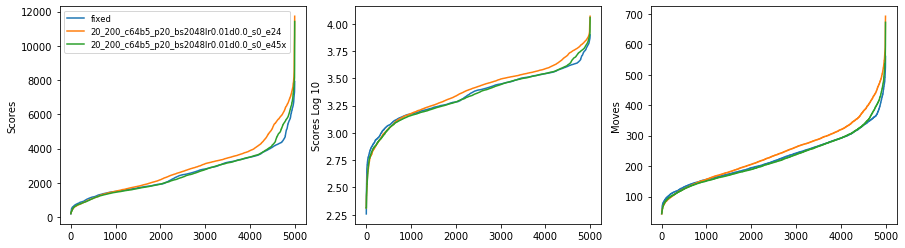

In [14]:
plot_results(s_list, log_scores, m_list, names)

In [86]:
stats_test(log_scores[0], log_scores[1])
stats_test(log_scores[0], log_scores[2])

----------
Ks_2sampResult(statistic=0.09179999999999999, pvalue=8.164949296905858e-19)
Ttest_indResult(statistic=-6.778374075864114, pvalue=1.2858405114988983e-11)
----------
Ks_2sampResult(statistic=0.03700000000000003, pvalue=0.0020593763872483514)
Ttest_indResult(statistic=1.4976589284632298, pvalue=0.134253726565981)


Best network as measured by 200 game eval during training is stronger than the last network before patience ran out. Indicates that the difference in 200 game eval is mirrored by this 5000 game eval. The best network was statistically significantly stronger than fixed, whereas the final network was not statistically stronger (curves appear stronger though). 

#### Picking the best seed
200 game eval during training actually is fairly consistent with the 5000 game eval. This makes me more confident in using the 200 game eval for early stopping and model selection. Seed 4 gave the best results.

In [15]:
names = [f'20200121/20_200_c64b5_p20_bs2048lr0.01d0.0_s{s}_best'
         for s in range(5)]

s_list, m_list, log_scores = get_results(names)
names = [str(s) for s in range(5)]

(5, 5000)
[3.38747116 3.35869122 3.37949065 3.35821884 3.41468338]


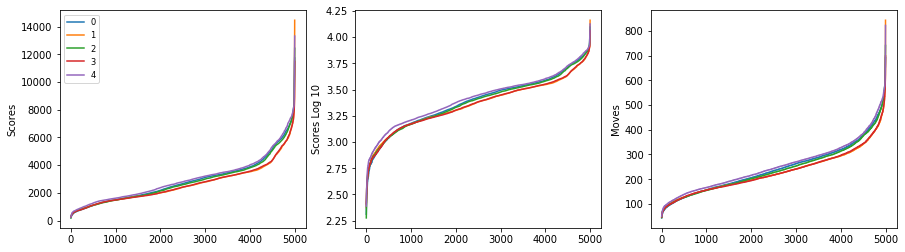

In [16]:
plot_results(s_list, log_scores, m_list, names)

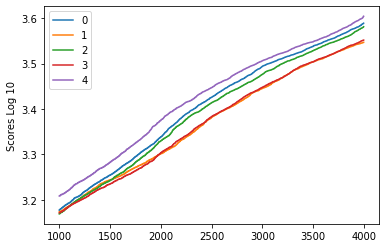

In [17]:
for s in log_scores:
    plt.plot(np.arange(1000,4000), s[1000:4000])
plt.ylabel('Scores Log 10')
plt.legend(names)
plt.show()

In [17]:
stats_test(log_scores[0], log_scores[4])

----------
Ks_2sampResult(statistic=0.0412, pvalue=0.00041153925306214697)
Ttest_indResult(statistic=-5.38817305998832, pvalue=7.280269521446764e-08)


## ConvNets
Achieved much higher 200 game estimated strengths using conv nets, especially with one-hot encoded tiles.

In [20]:
names = ['fixed',
         '20200121/20_200_c64b5_p20_bs2048lr0.01d0.0_s4_best',
         '20200122/onehot_20_200_c64b5_p20_bs2048lr0.01d0.0_s0_best',
         '20200122/onehot_20_200_c128b5_p20_bs2048lr0.01d0.0_s0_best']

s_list, m_list, log_scores = get_results(names)
names = ['fixed'] + [n[9:] for n in names[1:]]

(4, 5000)
[3.35464984 3.41468338 3.98731202 4.00092931]


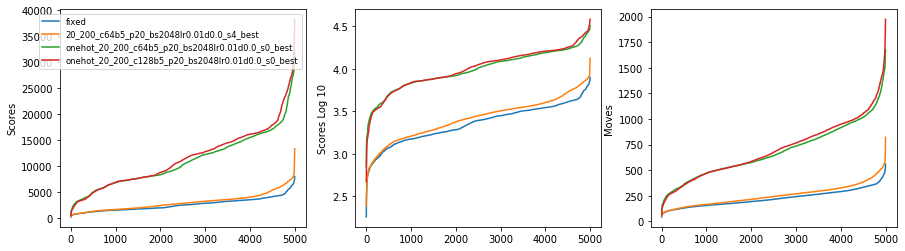

In [21]:
plot_results(s_list, log_scores, m_list, names)

In [22]:
stats_test(log_scores[1], log_scores[2])
stats_test(log_scores[2], log_scores[3])

----------
Ks_2sampResult(statistic=0.788, pvalue=0.0)
Ttest_indResult(statistic=-121.75428315303667, pvalue=0.0)
----------
Ks_2sampResult(statistic=0.0496, pvalue=9.061553977540016e-06)
Ttest_indResult(statistic=-2.882426343405649, pvalue=0.003954716209168653)


These new one-hot conv nets blow the previous networks completely out of the water. 

#### Picking the best seed

In [27]:
names = [f'20200123/onehot_20_200_c128b5_p20_bs2048lr0.01d0.0_s{s}_best'
         for s in range(5)]

s_list, m_list, log_scores = get_results(names)
names = [str(s) for s in range(5)]

(5, 5000)
[4.0041384  3.99403382 4.02593098 3.95480562 3.96849989]


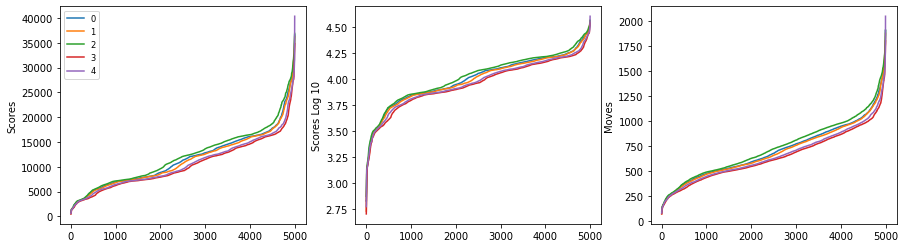

In [28]:
plot_results(s_list, log_scores, m_list, names)

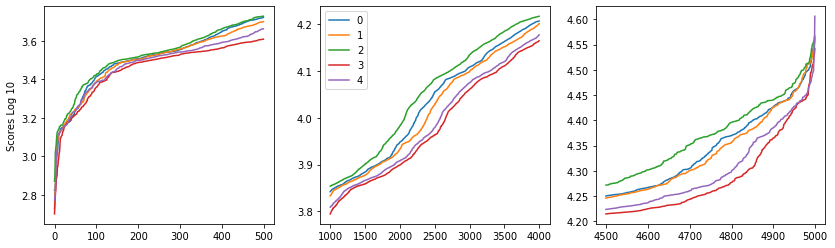

In [38]:
plt.figure(figsize=(14, 4))
for i, r1, r2 in zip(range(3), (0, 1000, 4500), (500, 4000, 5000)):
    plt.subplot(1,3,i+1)
    for s in log_scores:
        plt.plot(np.arange(r1, r2), s[r1:r2])
    if i == 0: plt.ylabel('Scores Log 10')
    if i == 1: plt.legend(names)
plt.show()

Although seed 4 was best in the 200 games eval, seed 2 is clearly best in the 5000 game eval. Will use seed 2 to play next set of selfplay games.

#### FastNet
Selfplay takes too long with the current ConvNet. Made a smaller network with less layers.

Timings:
* Training: 29/s vs 20/s => 30% time reduction
* 5000 mcts: 146 (3.96) vs 186 (4.02) => 20% time reduction
* 3x 50 mcts cudnn.benchmark: with 42.75 vs w/o 42.86 => 0.2% reduction

In [5]:
names = [f'20200125/fastnet_20_200_c128b4_p20_bs2048lr0.01d0.0_s{s}_best'
         for s in range(5)]

s_list, m_list, log_scores = get_results(names)
names = [str(s) for s in range(5)]

(5, 5000)
[3.96759019 3.90103514 3.92152461 3.91050315 3.87309966]


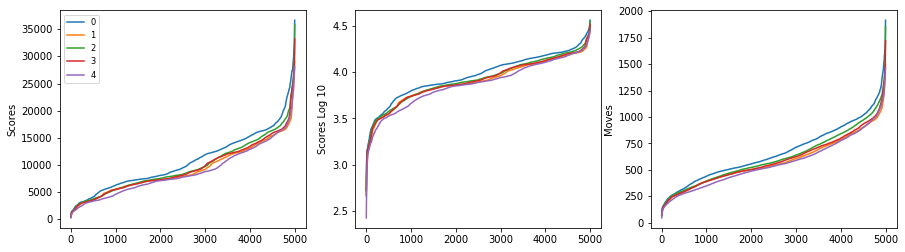

In [6]:
plot_results(s_list, log_scores, m_list, names)

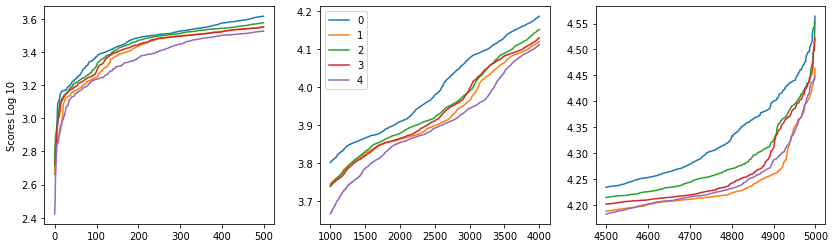

In [7]:
plt.figure(figsize=(14, 4))
for i, r1, r2 in zip(range(3), (0, 1000, 4500), (500, 4000, 5000)):
    plt.subplot(1,3,i+1)
    for s in log_scores:
        plt.plot(np.arange(r1, r2), s[r1:r2])
    if i == 0: plt.ylabel('Scores Log 10')
    if i == 1: plt.legend(names)
plt.show()

(2, 5000)
[4.02593098 3.96759019]


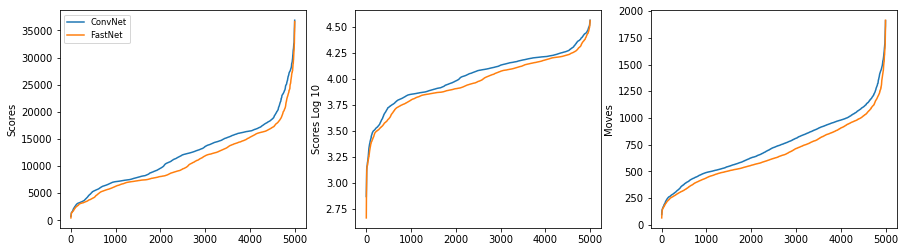

ConvNet is clearly superior to FastNet. However, time savings may be worth it.


In [12]:
names = ['20200123/onehot_20_200_c128b5_p20_bs2048lr0.01d0.0_s2_best',
         '20200125/fastnet_20_200_c128b4_p20_bs2048lr0.01d0.0_s0_best'
         ]

s_list, m_list, log_scores = get_results(names)
names = ['ConvNet', 'FastNet']

plot_results(s_list, log_scores, m_list, names)
print('ConvNet is clearly superior to FastNet. However, time savings may be worth it.')

In [20]:
np.sum(m_list[0] - m_list[1]) / np.sum(m_list[0])

0.09842653101461285

Increased strength of ConvNet leads to 10% more moves, so 10% of time reduction is due to less moves. The rest is due to the network.